# 582744 Advanced Course in Machine Learning

## Exercise 6.4: Character classification with CNNs

This exercise contains most of the code needed in a Python jupyter notebook, you will be asked to fill in some important parts.  Just read the text and run each code cell by selecting and clicking the "run cell" button (play-like button), or by pressing shift-Enter.

In this exercise, we'll continue on the theme of exercise 6.3, i.e., classifying images of letters, but instead of MLP we'll use convolutional neural networks (CNNs).

The notebook for this exercise is based on a notebook created by Markus Koskela at [CSC](https://www.csc.fi/home).

Continue by running the cells below...

In [1]:
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, MaxPooling2D
from keras.layers.convolutional import Conv2D 
from keras.utils import np_utils

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request
import os.path

Using TensorFlow backend.


Next we'll download the notMNIST data (if it hasn't been already). This might take a few seconds as it's a 9.9 MB file.

We're using a small subset of notMNIST which contains only ten classes, letters 'A' to 'J'.

In [2]:
file_name = 'notMNIST_small.npz'
if not os.path.isfile(file_name):
    (tmp, headers) = urllib.request.urlretrieve("https://www.cs.helsinki.fi/u/mvsjober/misc/notMNIST_small.npz", file_name)
    if os.path.isfile(file_name):
        print('Successfully downloaded', file_name)
else:
    print(file_name, 'was already downloaded.')

notMNIST_small.npz was already downloaded.


Next, we'll split the data into a training set and a testset and make some format changes.

In [3]:
split_point = 15000
data = np.load('notMNIST_small.npz')
X_train = data['images'][:split_point,:,:]
y_train = data['labels'][:split_point]
X_test = data['images'][split_point:,:,:]
y_test = data['labels'][split_point:]
nb_classes = 10

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

# one-hot encoding:
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

print()
print('notMNIST_small data loaded: train:',len(X_train),'test:',len(X_test))
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('Y_train:', Y_train.shape)


notMNIST_small data loaded: train: 15000 test: 3724
X_train: (15000, 28, 28)
y_train: (15000,)
Y_train: (15000, 10)


The training data (`X_train`) is a 3rd-order tensor of size (15000, 28, 28), i.e., it consists of 15000 images of size 28x28 pixels. `y_train` is a 15000-dimensional vector containing the correct classes (0="A", 1="B", etc) for each training digit, and `Y_train` is a [one-hot](https://en.wikipedia.org/wiki/One-hot) encoding of `y_train`.

We'll have to do a bit of tensor manipulations, depending on the used backend (Theano or Tensorflow).

In [4]:
# input image dimensions
img_rows, img_cols = 28, 28

if K.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
print('X_train:', X_train.shape)

X_train: (15000, 28, 28, 1)


### Initialization

Now, let's create an CNN model that outperforms the MLP model in the previous exercise!

**Here is where you should add some code of your own!**

Add at least one or more 2D convolutional layers, and max pooling. Non-linearities and dropouts as usual. The methods needed are described in [Keras' documentation](https://keras.io/). You will also need to `Flatten()` the output at some point to transform the 2D matrices to vector form (as the output is a vector with the 10 classes).

The first layer needs to specify the input shape by giving the parameter `input_shape=input_shape` (the variable was defined in an earlier cell).

The output of the last layer needs to be a probability distribution over the 10 classes to match the groundtruth (`Y_train`), i.e., a 10-dimensional vector that sums up to 1.0.

In [32]:
# Model initialization:
model = Sequential()

# Example lines, but change these to do CNN!
model.add(Dense(units=128, input_shape=input_shape))
model.add(Conv2D(32, (3, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(40, activation='tanh'))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 28, 28, 128)       256       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 26, 26, 32)        36896     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 5408)              0         
_________________________________________________________________
dense_34 (Dense)             (None, 100)               540900    
_________________________________________________________________
dropout_12 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 40)                4040      
__________

You can also visualise it like this:

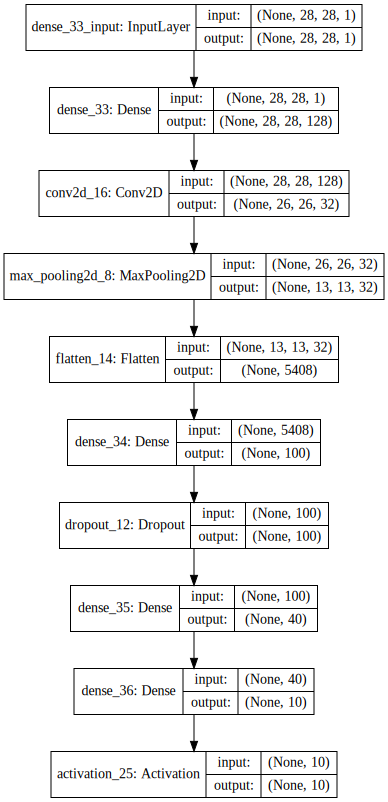

In [35]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

### Learning

Now let's train the CNN model. Note that we do not need the `reshape()` function as in the MLP case.

This is a relatively complex model, so training is considerably slower than with MLPs.  You probably need to run it more epochs as it is a more complex model. (Here we use 3 just for illustration.)

In [33]:
%%time

epochs = 3 # one epoch typically takes a minute or two

history = model.fit(X_train, 
                    Y_train, 
                    epochs=epochs, 
                    batch_size=128,
                    verbose=2)

Epoch 1/3
53s - loss: 0.7014 - acc: 0.8163
Epoch 2/3
52s - loss: 0.3821 - acc: 0.8982
Epoch 3/3
53s - loss: 0.3168 - acc: 0.9093
CPU times: user 9min 52s, sys: 19.9 s, total: 10min 12s
Wall time: 2min 39s


Now let's see how the training progressed by plotting the loss and accuracy over time.

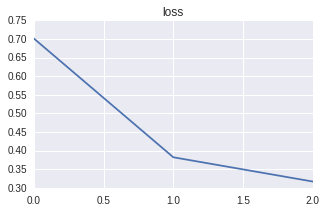

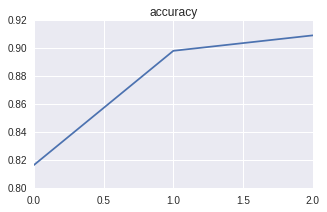

In [36]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['acc'])
plt.title('accuracy')

### Inference

Now, let's see how well the model can generalize to data it hasn't seen before, i.e., the test data. You should try to do better than the MLP model in the previous exercise.

In [34]:
scores = model.evaluate(X_test, Y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 90.71%


We can also inspect the results in more detail. Let's begin by defining a helper function to show the failure cases of our classifier.

In [37]:
def class_to_char(cl):
    return chr(ord('A')+int(cl))

def char_to_class(ch):
    return ord(ch)-ord('A')

def show_failures(predictions, trueclass=None, predictedclass=None, maxtoshow=10):
    if trueclass is not None:
        trueclass = char_to_class(trueclass)
    rounded = np.argmax(predictions, axis=1)
    errors = rounded!=y_test
    print('Showing max', maxtoshow, 'first failures. '
          'The predicted class is shown first and the correct class in parenthesis.')
    ii = 0
    plt.figure(figsize=(maxtoshow, 1))
    for i in range(X_test.shape[0]):
        if ii>=maxtoshow:
            break
        if errors[i]:
            if trueclass is not None and y_test[i] != trueclass:
                continue
            if predictedclass is not None and predictions[i] != predictedclass:
                continue
            plt.subplot(1, maxtoshow, ii+1)
            plt.axis('off')
            if K.image_dim_ordering() == 'th':
                plt.imshow(X_test[i,0,:,:], cmap="gray")
            else:
                plt.imshow(X_test[i,:,:,0], cmap="gray")
            plt.title("%s (%s)" % (class_to_char(rounded[i]), class_to_char(y_test[i])))
            ii = ii + 1

Here are the first 10 test digits the CNN classified to a wrong class:

Showing max 10 first failures. The predicted class is shown first and the correct class in parenthesis.


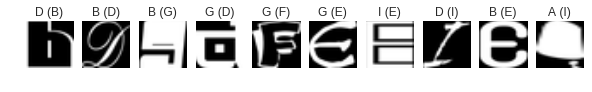

In [38]:
predictions = model.predict(X_test)

show_failures(predictions)

We can use `show_failures()` to inspect failures in more detail. For example, here are failures in which the true class was "A":

Showing max 10 first failures. The predicted class is shown first and the correct class in parenthesis.


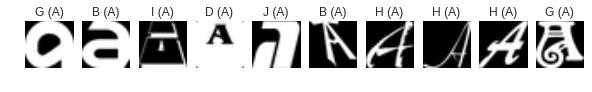

In [39]:
show_failures(predictions, trueclass="A")

Now continue to tune your model by adding layers, and check literature on convolutional neural network models.